# Setup

In [16]:
import numpy as np
import seaborn as sns
import pandas as pd
import glob

# Functions

In [17]:
def read_csv(filepath, cols, names):
    df = pd.read_csv(filepath, usecols = cols, names = names, header = None)
    df = df.drop([0], axis = 0) # Remove first row (headers)
    df = df.astype('float64') # Cast data to floats
    
    return df

In [34]:
def read_acc_mag_csvs(class_name, set_name, column_names):
    X = pd.DataFrame()
    y = pd.DataFrame(columns=['class'])
    
    for file in glob.glob('data/cleaned/' + set_name + '/' + class_name + '*.csv'):

        if 'acc' in file:
            mag_file = file.replace('acc', 'mag')
            
            df_acc = read_csv(file, [1,2,3], column_names[:3])
            df_mag = read_csv(mag_file, [1,2,3], column_names[3:])
            
            df = pd.concat([df_acc, df_mag], axis=1, join='inner')
            X = X.append(df, ignore_index=True)
            
            '''
            print(file + '\tLength: ', end='')
            print(len(df_acc))
            print(mag_file + '\tLength: ', end='')
            print(len(df_mag))
            '''
            
    y['class'] = [class_name for i in range(len(X))]
        
    return X, y

In [52]:
def read_acc_gyro_csvs(class_name, set_name, column_names):
    X = pd.DataFrame()
    y = pd.DataFrame(columns=['class'])
    
    for file in glob.glob('data/cleaned/' + set_name + '/move/' + class_name + '*.csv'):

        if 'acc' in file:
            gyro_file = file.replace('acc', 'gyro')
            
            df_acc = read_csv(file, [2,4,3], column_names[:3])
            df_gyro = read_csv(gyro_file, [2,3,4], column_names[3:])
            
            df = pd.concat([df_acc, df_gyro], axis=1, join='inner')
            X = X.append(df, ignore_index=True)
            
            '''
            print(file + '\tLength: ', end='')
            print(len(df_acc))
            print(mag_file + '\tLength: ', end='')
            print(len(df_mag))
            '''
            
    y['class'] = [class_name for i in range(len(X))]
        
    return X, y

In [38]:
def get_acc_mag_data(set_name):
    acc_mag_col_names = ['ax', 'ay', 'az', 'mx', 'my', 'mz']

    # Still
    X_sit, y_sit = read_acc_mag_csvs('sit', set_name, acc_mag_col_names)
    X_stand, y_stand = read_acc_mag_csvs('stand', set_name, acc_mag_col_names)
    X_lie, y_lie = read_acc_mag_csvs('lie', set_name, acc_mag_col_names)

    # Movement
    X_sit_to_stand, y_sit_to_stand = read_acc_mag_csvs('move/sit_to_stand', set_name, acc_mag_col_names)
    X_stand_to_sit, y_stand_to_sit = read_acc_mag_csvs('move/stand_to_sit', set_name, acc_mag_col_names)

    X = pd.concat([X_sit, X_stand, X_lie, X_sit_to_stand, X_stand_to_sit], ignore_index=True)
    y = pd.concat([y_sit, y_stand, y_lie, y_sit_to_stand, y_stand_to_sit], ignore_index=True)

    return X, y

In [41]:
def get_acc_gyro_data(set_name):
    acc_gyro_col_names = ['ax', 'ay', 'az', 'gx', 'gy', 'gz']

    # Movement
    X_walk, y_walk = read_acc_gyro_csvs('walk', set_name, acc_gyro_col_names)
    X_run, y_run = read_acc_gyro_csvs('run', set_name, acc_gyro_col_names)

    X = pd.concat([X_walk, X_run], ignore_index=True)
    y = pd.concat([y_walk, y_run], ignore_index=True)

    return X, y

# Get data sets

In [39]:
X_train_acc_mag, y_train_acc_mag = get_acc_mag_data('train')
X_test_acc_mag, y_test_acc_mag = get_acc_mag_data('test')

In [53]:
X_train_acc_gyro, y_train_acc_gyro = get_acc_gyro_data('train')
X_test_acc_gyro, y_test_acc_gyro = get_acc_gyro_data('test')

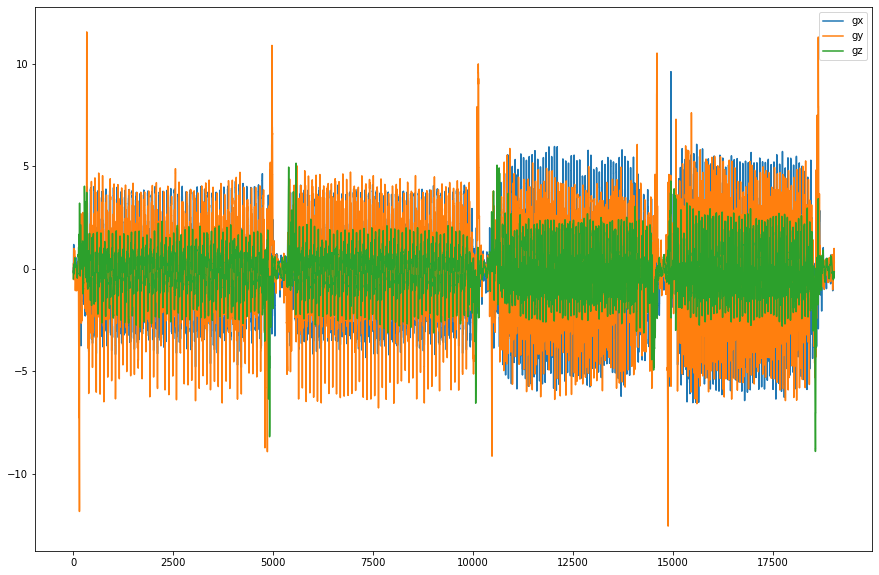

In [64]:
X_train_acc_gyro[X_train_acc_gyro.columns[3:6]].plot(figsize=(15,10))